In [ ]:
import os, sys
import pickle
!pip install transformers
!pip install openl3
!pip install python_speech_features

from functions import *
classes = ['CT','GR','MS','STR','TT','S']

import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 36.0 MB/s 
     |████████████████████████████████| 120 kB 73.1 MB/s 
     |████████████████████████████████| 6.6 MB 48.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 323 kB 11.9 MB/s 
     |████████████████████████████████| 2.9 MB 54.3 MB/s 
     |████████████████████████████████| 388 kB 71.2 MB/s 
     |████████████████████████████████| 26.9 MB 1.3 MB/s 
  Created wheel for openl3: filename=openl3-0.4.1-py2.py3-none-any.whl size=249325522 sha256=c8bb438459c3f194432b325a6a32951d38448df87266571adcf8d8d64f839ab3
  Stored in directory: /root/.cache/pip/wheels/ee/f3/9d/53bd35d9df458d9a3b19d9c5310735727bbabaf6a8e99e35c0
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110743 sha256=c460dee0afffaf1a53b67dbde9769ad6f5af9b83abf

In [ ]:
os.chdir('/content/drive/My Drive/Files')
all_files = os.listdir()
files = list(np.sort([f for f in all_files if '.wav' in f]))
test_split_1 = list(np.sort(['2019072151710.wav','20190705120137.wav','20190702111307.wav']))
test_split_2 = list(np.sort(['20200113130008.wav','20190726122330.wav']))
test_files = list(np.sort(list(test_split_1)+list(test_split_2)))
train_split_1 = np.sort(list(set(files)-set(test_split_1)))
train_split_2 = np.sort(list(set(files)-set(test_split_2)))

# Creating Datasets

In [ ]:
def get_pooled_vector(w2v2_vector,pooling):
    if pooling == 'first':
        w2v2_vector = w2v2_vector[0]
    elif pooling == 'last':
        w2v2_vector = w2v2_vector[-1]
    elif pooling == 'middle':
        w2v2_vector =  w2v2_vector[len(w2v2_vector)//2]
    elif pooling == 'mean':
        w2v2_vector = w2v2_vector.mean(axis=0)
    return(w2v2_vector)

def create_pooled_features(files,pooling='mean'):
    logspec_dataset = []
    w2v2_dataset = pd.DataFrame()
    labels_dataset = pd.DataFrame()

    for k in range(len(files)):
        print(files[k])
        name = files[k].split('.')[0]
        logspec_file = name + '_SpecDB'
        w2v2_file = name + '_W2V2'
        labels_file = name + '_Labels'

        logspec = pd.read_pickle(logspec_file)
        logspec = logspec.T
        w2v2 = pd.read_pickle(w2v2_file)
        labels = pd.read_pickle(labels_file)

        i = 0
        while i< len(labels)-25:

            logspec_vector = logspec[i:i+25]
            w2v2_vector = w2v2[i:i+25]
            labels_vector = labels[i:i+25]

            w2v2_vector = get_pooled_vector(w2v2_vector,pooling)
            w2v2_dataset = w2v2_dataset.append(w2v2_vector,ignore_index=True)

            labels_temp = np.array([0]*8)
            for j in range(len(labels_vector)-1):
                labels_current = np.array(labels_vector.iloc[j].tolist())
                labels_temp = labels_temp | labels_current
            labels_dataset = labels_dataset.append(pd.Series(labels_temp),ignore_index=True)
            i+=5

            logspec_dataset.append(logspec_vector.values.tolist())

    labels_dataset = labels_dataset.astype(int)
    return(logspec_dataset,w2v2_dataset,labels_dataset)

def create_pooled_labels(filepath):
    labels_dataset = pd.DataFrame()
    name = filepath.split('.')[0]
    labels_file = name + '_Labels'
    labels = pd.read_pickle(labels_file)

    i = 0
    while i< len(labels)-25:
        labels_vector = labels[i:i+25]
        labels_temp = np.array([0]*8)
        for j in range(len(labels_vector)-1):
            labels_current = np.array(labels_vector.iloc[j].tolist())
            labels_temp = labels_temp | labels_current
        labels_dataset = labels_dataset.append(pd.Series(labels_temp),ignore_index=True)
        i+=5

    label_filename = name + '_Labels_Final'
    labels_dataset.to_pickle(label_filename)
    labels_dataset = labels_dataset.astype(int)
    return(labels_dataset)



def merge_datasets(files,data_type,split=''):
    
    w2v2_dataset = pd.DataFrame()
    labels_dataset = pd.DataFrame()
    openl3_dataset = pd.DataFrame()

    for i in range(len(files)):        
        name = files[i].split('.')[0]
        print(name)
        logspec_file = name + '_SpecDB_Final'
        w2v2_file = name + '_W2V2_Final'
        openl3_file = name + '_OpenL3'
        labels_file = name + '_Labels_Final'

        with open(logspec_file, "rb") as fp: logspec = pickle.load(fp)
        w2v2 = pd.read_pickle(w2v2_file)
        openl3 = pd.read_pickle(openl3_file)
        labels = pd.read_pickle(labels_file)        

        if i==0:
            logspec_dataset = np.array(logspec)
        else:
            logspec_dataset = np.concatenate((logspec_dataset, np.array(logspec)), axis=0)

        w2v2_dataset = w2v2_dataset.append(w2v2)
        openl3_dataset = openl3_dataset.append(openl3)
        labels_dataset = labels_dataset.append(labels)
    
    logspec_filename = data_type + '_logspec' + split
    w2v2_filename = data_type + '_w2v2' + split
    openl3_filename = data_type + '_openl3' + split
    labels_filename = data_type + '_labels' + split

    with open(logspec_filename, 'wb') as fp: pickle.dump(logspec_dataset, fp)
    w2v2_dataset.to_pickle(w2v2_filename)
    openl3_dataset.to_pickle(openl3_filename)    
    labels_dataset.to_pickle(labels_filename)

In [ ]:
os.chdir('/content/drive/My Drive/Files')
all_files = os.listdir()
files = list(np.sort([f for f in all_files if '.wav' in f]))
test_split_1 = list(np.sort(['2019072151710.wav','20190705120137.wav','20190702111307.wav']))
test_split_2 = list(np.sort(['20200113130008.wav','20190726122330.wav']))
test_files = list(np.sort(list(test_split_1)+list(test_split_2)))
train_split_1 = np.sort(list(set(files)-set(test_split_1)))
train_split_2 = np.sort(list(set(files)-set(test_split_2)))


print('train_1')
print(train_split_1)
merge_datasets(train_split_1,data_type='train',split='_paper1')

print('train_2')
print(train_split_2)
merge_datasets(train_split_2,data_type='train',split='_paper2')

print('test_1')
print(test_split_1)
merge_datasets(test_split_1,data_type='test',split='_paper1')

print('test_2')
print(test_split_2)
merge_datasets(test_split_2,data_type='test',split='_paper2')

train_1
['20190703114117.wav' '20190717111033.wav' '20190717114527.wav'
 '20190717115805.wav' '20190722110526.wav' '20190722112509.wav'
 '20190722114950.wav' '20190722145736.wav' '20190722154602.wav'
 '20190722155316.wav' '20190725112942.wav' '20190725120856.wav'
 '20190725145125.wav' '20190725150456.wav' '20190725152424.wav'
 '20190726113303.wav' '20190726122330.wav' '20190726162551.wav'
 '20190730115500.wav' '20200113130008.wav' 'Sample.wav']
20190703114117
20190717111033
20190717114527
20190717115805
20190722110526
20190722112509
20190722114950
20190722145736
20190722154602
20190722155316
20190725112942
20190725120856
20190725145125
20190725150456
20190725152424
20190726113303
20190726122330
20190726162551
20190730115500
20200113130008
Sample
train_2
['20190702111307.wav' '20190703114117.wav' '20190705120137.wav'
 '20190717111033.wav' '20190717114527.wav' '20190717115805.wav'
 '2019072151710.wav' '20190722110526.wav' '20190722112509.wav'
 '20190722114950.wav' '20190722145736.wav' '2

In [ ]:
y_train = pd.read_pickle('test_labels_paper1')
y_n = y_train[3]
y_s = y_train[4]
y_sn = y_train[5]

y_replace = y_s | y_n | y_sn
y_train.drop([3,4,5], inplace=True, axis=1)
y_train.columns = range(5)
y_train[5] = y_replace
y_train.to_pickle('test_labels_paper1')

# Loading the Dataset

In [ ]:
os.chdir('/content/drive/My Drive/Files')

#Log Spec Features
with open('train_logspec_paper1', "rb") as fp: train_logspec = pickle.load(fp)
with open('test_logspec_paper1', "rb") as fp: test_logspec = pickle.load(fp)    

#W2V2 Features
train_w2v2 = pd.read_pickle('train_w2v2_paper1')
test_w2v2 = pd.read_pickle('test_w2v2_paper1')

#OpenL3 features
train_openl3 = pd.read_pickle('train_openl3_paper1')
test_openl3 = pd.read_pickle('test_openl3_paper1')


#Labels
y_train = pd.read_pickle('train_labels_paper1')
y_test = pd.read_pickle('test_labels_paper1')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train = np.array([x.T.reshape( (128, 25, 1) ) for x in train_logspec])
X_test = np.array([x.T.reshape( (128, 25, 1) ) for x in test_logspec])

del train_logspec
del test_logspec

X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
train_w2v2 = tf.convert_to_tensor(train_w2v2)
train_openl3 = tf.convert_to_tensor(train_openl3)

X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)
test_w2v2 = tf.convert_to_tensor(test_w2v2)
test_openl3 = tf.convert_to_tensor(test_openl3)

# Classification

## Logspec Classifier

In [ ]:
cnn_input_shape = (128, 25, 1)

cnn_input = Input(cnn_input_shape)

model = Sequential()
model.add(Conv2D(128, (3, 3), strides=(1, 1), input_shape=cnn_input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((4, 2), strides=(2, 2)))


model.add(Conv2D(64, (3, 3), padding="valid"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((4, 2), strides=(2,2)))


model.add(Conv2D(32, (3, 3), padding="valid"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((4, 2), strides=(2,2)))

model.add(Flatten())

cnn_embedding = model(cnn_input)
dense_1 = Dense(64, activation='relu')(cnn_embedding)
dense_2 = Dense(32, activation='relu')(dense_1)
prediction = Dense(6, activation='sigmoid')(dense_2) 
logspec_model = Model(inputs=cnn_input, outputs=prediction)

# tf.keras.utils.plot_model(logspec_model, show_shapes=True,expand_nested=True)

In [ ]:
logspec_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=['accuracy'])

history = logspec_model.fit(x=X_train, y=y_train, epochs=10, batch_size=64, validation_split=.1)

loss, accuracy = logspec_model.evaluate(x=X_test,y=y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/10
1747/1747 [==============================] - 52s 24ms/step - loss: 0.4174 - accuracy: 0.4098 - val_loss: 0.4250 - val_accuracy: 0.4942
Epoch 2/10
1747/1747 [==============================] - 39s 22ms/step - loss: 0.3854 - accuracy: 0.4596 - val_loss: 0.4089 - val_accuracy: 0.4988
Epoch 3/10
1747/1747 [==============================] - 39s 22ms/step - loss: 0.3748 - accuracy: 0.4785 - val_loss: 0.4215 - val_accuracy: 0.5009
Epoch 4/10
1747/1747 [==============================] - 40s 23ms/step - loss: 0.3685 - accuracy: 0.4882 - val_loss: 0.4189 - val_accuracy: 0.5134
Epoch 5/10
1747/1747 [==============================] - 39s 22ms/step - loss: 0.3632 - accuracy: 0.4966 - val_loss: 0.5643 - val_accuracy: 0.3657
Epoch 6/10
1747/1747 [==============================] - 38s 22ms/step - loss: 0.3591 - accuracy: 0.5036 - val_loss: 0.4972 - val_accuracy: 0.4321
Epoch 7/10
1747/1747 [==============================] - 39s 23ms/step - loss: 0.3549 - accuracy: 0.5100 - val_loss: 0.4187 -

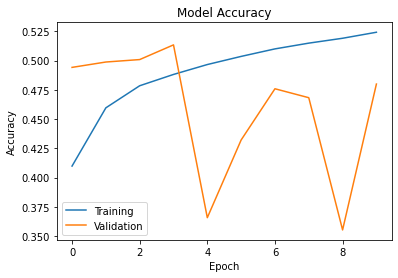

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')

plt.show()

In [ ]:
logspec_model.save('logspec_model_paper_2')

## 2 branch Classifier

In [ ]:
cnn_input_shape = (128, 25, 1)
w2v2_input_shape = (768,)

cnn_input = Input(cnn_input_shape)
w2v2_input = Input(w2v2_input_shape)

cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), strides=(1, 1), input_shape=cnn_input_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D((4, 2), strides=(2, 2)))


cnn_model.add(Conv2D(16, (3, 3), padding="valid"))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D((4, 2), strides=(2,2)))


cnn_model.add(Conv2D(8, (3, 3), padding="valid"))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D((4, 2), strides=(2,2)))

cnn_model.add(Flatten())
cnn_embedding = cnn_model(cnn_input)

w2v2_model = Sequential()
w2v2_model.add(Dense(256, activation='relu'))
w2v2_embedding = w2v2_model(w2v2_input)


concat = tf.keras.layers.Concatenate()([cnn_embedding, w2v2_embedding])
dense_1 = Dense(64, activation='relu')(concat)
dense_2 = Dense(32, activation='relu')(dense_1)
prediction = Dense(6, activation='sigmoid')(dense_2) 
model = Model(inputs=[cnn_input, w2v2_input], outputs=prediction)

#tf.keras.utils.plot_model(model, show_shapes=True,expand_nested=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=['accuracy'])

history = model.fit(x=[X_train,train_w2v2], y=y_train, epochs=10, batch_size=64, validation_split=.1)

loss, accuracy = model.evaluate(x=[X_test,test_w2v2],y=y_test)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/10
1668/1668 [==============================] - 17s 9ms/step - loss: 0.3992 - accuracy: 0.4253 - val_loss: 0.4093 - val_accuracy: 0.4970
Epoch 2/10
1668/1668 [==============================] - 15s 9ms/step - loss: 0.3658 - accuracy: 0.4854 - val_loss: 0.3924 - val_accuracy: 0.5350
Epoch 3/10
1668/1668 [==============================] - 15s 9ms/step - loss: 0.3556 - accuracy: 0.5000 - val_loss: 0.3815 - val_accuracy: 0.5367
Epoch 4/10
1668/1668 [==============================] - 16s 10ms/step - loss: 0.3492 - accuracy: 0.5087 - val_loss: 0.4080 - val_accuracy: 0.5443
Epoch 5/10
1668/1668 [==============================] - 15s 9ms/step - loss: 0.3437 - accuracy: 0.5158 - val_loss: 0.3713 - val_accuracy: 0.5528
Epoch 6/10
1668/1668 [==============================] - 15s 9ms/step - loss: 0.3388 - accuracy: 0.5218 - val_loss: 0.3805 - val_accuracy: 0.5645
Epoch 7/10
1668/1668 [==============================] - 15s 9ms/step - loss: 0.3347 - accuracy: 0.5263 - val_loss: 0.4069 - val_a

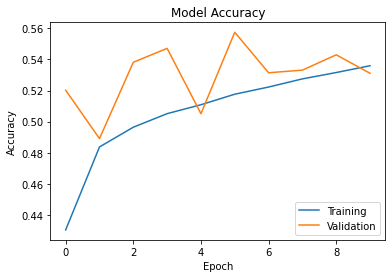

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')

plt.show()

In [ ]:
model.save('2branch_model_paper_1')

## 3 branch Classifier

In [ ]:
cnn_input_shape = (128, 25, 1)
w2v2_input_shape = (768,)
openl3_input_shape = (512,)

cnn_input = Input(cnn_input_shape)
w2v2_input = Input(w2v2_input_shape)
openl3_input = Input(openl3_input_shape)

logspec_model = Sequential()
logspec_model.add(Conv2D(32, (3, 3), strides=(1, 1), input_shape=cnn_input_shape))
logspec_model.add(BatchNormalization())
logspec_model.add(Activation('relu'))
logspec_model.add(MaxPooling2D((4, 2), strides=(2, 2)))


logspec_model.add(Conv2D(16, (3, 3), padding="valid"))
logspec_model.add(BatchNormalization())
logspec_model.add(Activation('relu'))
logspec_model.add(MaxPooling2D((4, 2), strides=(2,2)))


logspec_model.add(Conv2D(8, (3, 3), padding="valid"))
logspec_model.add(BatchNormalization())
logspec_model.add(Activation('relu'))
logspec_model.add(MaxPooling2D((4, 2), strides=(2,2)))

logspec_model.add(Flatten())

cnn_embedding = logspec_model(cnn_input)

w2v2_model = Sequential()
w2v2_model.add(Dense(256, activation='relu'))
w2v2_embedding = w2v2_model(w2v2_input)

openl3_model = Sequential()
openl3_model.add(Dense(256, activation='relu'))
openl3_embedding = openl3_model(openl3_input)


concat = tf.keras.layers.Concatenate(name='concat')([cnn_embedding, w2v2_embedding,openl3_embedding])
dense_1 = Dense(64, activation='relu', name='dense1')(concat)
dense_2 = Dense(32, activation='relu', name='dense2')(dense_1)
prediction = Dense(6, activation='sigmoid', name='output')(dense_2) 
model = Model(inputs=[cnn_input, w2v2_input,openl3_input], outputs=prediction)
#tf.keras.utils.plot_model(model, show_shapes=True,expand_nested=True)

In [ ]:
#Recorded
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=['accuracy'])

classes = ['CT','GR','MS','STR','TT','S']
history = model.fit(x=[X_train,train_w2v2,train_openl3], y=y_train, epochs=10, batch_size=64, validation_split=.1)

loss, accuracy = model.evaluate(x=[X_test,test_w2v2,test_openl3],y=y_test)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/10
1668/1668 [==============================] - 33s 14ms/step - loss: 0.3970 - accuracy: 0.4243 - val_loss: 0.3883 - val_accuracy: 0.5156
Epoch 2/10
1668/1668 [==============================] - 17s 10ms/step - loss: 0.3560 - accuracy: 0.4943 - val_loss: 0.3889 - val_accuracy: 0.5469
Epoch 3/10
1668/1668 [==============================] - 17s 10ms/step - loss: 0.3423 - accuracy: 0.5129 - val_loss: 0.4041 - val_accuracy: 0.5331
Epoch 4/10
1668/1668 [==============================] - 16s 10ms/step - loss: 0.3337 - accuracy: 0.5226 - val_loss: 0.3823 - val_accuracy: 0.5594
Epoch 5/10
1668/1668 [==============================] - 17s 10ms/step - loss: 0.3278 - accuracy: 0.5284 - val_loss: 0.3757 - val_accuracy: 0.5716
Epoch 6/10
1668/1668 [==============================] - 17s 10ms/step - loss: 0.3229 - accuracy: 0.5364 - val_loss: 0.3718 - val_accuracy: 0.5673
Epoch 7/10
1668/1668 [==============================] - 17s 10ms/step - loss: 0.3188 - accuracy: 0.5411 - val_loss: 0.3727 -

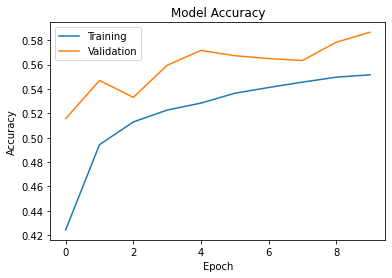

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')

plt.show()

In [ ]:
model.save('3branch_model_paper_1')

# Predictions and Post Processing

In [ ]:
os.chdir('/content/drive/My Drive/Files')
model_logspec = keras.models.load_model('logspec_model_paper_1')
model_2branch = keras.models.load_model('2branch_model_paper_1')
model_3branch = keras.models.load_model('3branch_model_paper_1')

### Framewise Predictions and mAP

In [ ]:
# predict_logspec = model_logspec.predict(x=X_test)
# predict_2branch = model_2branch.predict(x=[X_test,test_w2v2])
predict_3branch = model_3branch.predict(x=[X_test,test_w2v2,test_openl3])

In [ ]:
from sklearn.metrics import average_precision_score
print("mAP Logspec Test", average_precision_score(y_test, predict_logspec))
print("mAP 2 branch Test", average_precision_score(y_test, predict_2branch))
print("mAP 3 branch Test", average_precision_score(y_test, predict_3branch))

mAP Logspec Test 0.4883130840009217
mAP 2 branch Test 0.5058089810066405
mAP 3 branch Test 0.5369069581184612


### LogSpec Predictions

In [ ]:
#Threshold Tuning 
predict_logspec = model_logspec.predict(x=X_train)

In [ ]:
threshold_logspec = []
pred_df_logspec = pd.DataFrame(predict_logspec)
y_df = pd.DataFrame(y_train.numpy())
for i in range(6):
    class_df_logspec = pred_df_logspec[y_df[i] == 1]
    threshold_logspec.append(np.round(max((class_df_logspec[i].median()),0.05),2))

In [ ]:
classes = ['CT','GR','MS','STR','TT','S']
speech_classes = ['CT','GR','MS','TT']
noise_classes = ['STR','S']

predict = model_logspec.predict(x=X_test)
prediction = np.zeros(predict.shape)

#Using Contour threhsolding + annotation cues
for i in range(len(prediction)):
    contour = np.max(predict[i])

    speech_probs = [predict[i][0],predict[i][1],predict[i][2],predict[i][4]] 
    noise_probs = [predict[i][3],predict[i][5]] 
    speech_highest = sorted(range(len(speech_probs)), key=lambda i: speech_probs[i], reverse=True)[:2]
    noise_highest = np.argmax(noise_probs)
    speech_classes_present = [speech_classes[i] for i in speech_highest]
    noise_classes_present = noise_classes[noise_highest]
    classes_present = speech_classes_present.copy()
    classes_present.append(noise_classes_present)
    classes_index = [classes.index(i) for i in classes_present]

    for j in classes_index:
        if predict[i][j] > (contour*threshold_logspec[j]):     
            prediction[i][j] = 1

    if predict[i][5]>0.7 and prediction[i][5] == 1:
        prediction[i] = np.array([0,0,0,0,0,1])

class_p_r_f1 = precision_recall_fscore_support(y_test, prediction, average=None)
print('Precision:', np.round(class_p_r_f1[0],2))
print('Recall:', np.round(class_p_r_f1[1],2))
print('F1-Score:', np.round(class_p_r_f1[2],2))
print('Support:', np.round(class_p_r_f1[3],2))
macro_f1 = f1_score(y_test, prediction, average='macro')
print('Macro F1:', np.round(macro_f1,3))
weighted_f1 = f1_score(y_test, prediction, average='weighted')
print('Weighted F1:', np.round(weighted_f1,3))

Precision: [0.6  0.49 0.2  0.07 0.93 0.56]
Recall: [0.12 0.68 0.6  0.07 0.69 0.6 ]
F1-Score: [0.2  0.57 0.3  0.07 0.79 0.58]
Support: [2634 1537 1344  269 6802  955]
Macro F1: 0.42
Weighted F1: 0.575


In [ ]:
def frame_to_time(frame,hop_size=0.1):
  return frame*hop_size

os.chdir('/content/drive/My Drive/Files')

classes = ['CT','GR','MS','STR','TT','S']
speech_classes = ['CT','GR','MS','TT']
noise_classes = ['STR','S']

print(threshold_logspec)

for file in test_files:
    name = file.split('.')[0]
    print(name)
    logspec_file = name + '_SpecDB_Final'
    w2v2_file = name + '_W2V2_Final'
    labels_file = name + '_Labels_Final'
    openl3_file = name + '_OpenL3' 

    with open(logspec_file, "rb") as fp: logspec = pickle.load(fp)  
    w2v2 = pd.read_pickle(w2v2_file)
    openl3 = pd.read_pickle(openl3_file)
    y = pd.read_pickle(labels_file)

    X = np.array([np.array(x).T.reshape( (128, 25, 1) ) for x in logspec])
    del logspec
    X = tf.convert_to_tensor(X)
    y = tf.convert_to_tensor(y)
    w2v2 = tf.convert_to_tensor(w2v2)
    openl3 = tf.convert_to_tensor(openl3)

    predict = model_logspec.predict(x=X)
    prediction = np.zeros(predict.shape)

    for i in range(len(prediction)):
        contour = np.max(predict[i])

        speech_probs = [predict[i][0],predict[i][1],predict[i][2],predict[i][4]] 
        noise_probs = [predict[i][3],predict[i][5]] 
        speech_highest = sorted(range(len(speech_probs)), key=lambda i: speech_probs[i], reverse=True)[:2]
        noise_highest = np.argmax(noise_probs)
        speech_classes_present = [speech_classes[i] for i in speech_highest]
        noise_classes_present = noise_classes[noise_highest]
        classes_present = speech_classes_present.copy()
        classes_present.append(noise_classes_present)
        classes_index = [classes.index(i) for i in classes_present]

        for j in classes_index:
            if predict[i][j] > (contour*threshold_logspec[j]):     
                prediction[i][j] = 1    
        
        if predict[i][5]>0.7 and prediction[i][5] == 1:
            prediction[i] = np.array([0,0,0,0,0,1])

    prediction_name = name + '_Prediction_LogSpec'
    with open(prediction_name, 'wb') as fp: pickle.dump(prediction, fp)

[0.24, 0.51, 0.48, 0.18, 0.73, 0.62]
20190702111307
20190705120137
2019072151710
20190726122330
20200113130008


### 2 Branch Predictions

In [ ]:
#Threshold Tuning 
predict_2branch = model_2branch.predict(x=[X_train,train_w2v2])

In [ ]:
threshold_2branch = []
pred_df_2branch = pd.DataFrame(predict_2branch)
y_df = pd.DataFrame(y_train.numpy())
for i in range(6):
    class_df_2branch = pred_df_2branch[y_df[i] == 1]
    threshold_2branch.append(np.round(max((class_df_2branch[i].median()),0.05),2))

In [ ]:
classes = ['CT','GR','MS','STR','TT','S']
speech_classes = ['CT','GR','MS','TT']
noise_classes = ['STR','S']

predict = model_2branch.predict(x=[X_test,test_w2v2])
prediction = np.zeros(predict.shape)

#Using Contour threhsolding + annotation cues
for i in range(len(prediction)):
    contour = np.max(predict[i])

    speech_probs = [predict[i][0],predict[i][1],predict[i][2],predict[i][4]] 
    noise_probs = [predict[i][3],predict[i][5]] 
    speech_highest = sorted(range(len(speech_probs)), key=lambda i: speech_probs[i], reverse=True)[:2]
    noise_highest = np.argmax(noise_probs)
    speech_classes_present = [speech_classes[i] for i in speech_highest]
    noise_classes_present = noise_classes[noise_highest]
    classes_present = speech_classes_present.copy()
    classes_present.append(noise_classes_present)
    classes_index = [classes.index(i) for i in classes_present]

    for j in classes_index:
        if predict[i][j] > (contour*threshold_2branch[j]):     
            prediction[i][j] = 1

    if predict[i][5]>0.7 and prediction[i][5] == 1:
        prediction[i] = np.array([0,0,0,0,0,1])

class_p_r_f1 = precision_recall_fscore_support(y_test, prediction, average=None)
print('Precision:', np.round(class_p_r_f1[0],2))
print('Recall:', np.round(class_p_r_f1[1],2))
print('F1-Score:', np.round(class_p_r_f1[2],2))
print('Support:', np.round(class_p_r_f1[3],2))
macro_f1 = f1_score(y_test, prediction, average='macro')
print('Macro F1:', np.round(macro_f1,3))
weighted_f1 = f1_score(y_test, prediction, average='weighted')
print('Weighted F1:', np.round(weighted_f1,3))

Precision: [0.36 0.66 0.2  0.24 0.84 0.6 ]
Recall: [0.34 0.5  0.55 0.65 0.82 0.48]
F1-Score: [0.35 0.57 0.3  0.35 0.83 0.53]
Support: [2969 2729 1630 1155 9338 2989]
Macro F1: 0.489
Weighted F1: 0.617


In [ ]:
def frame_to_time(frame,hop_size=0.1):
  return frame*hop_size

os.chdir('/content/drive/My Drive/Files')

classes = ['CT','GR','MS','STR','TT','S']
speech_classes = ['CT','GR','MS','TT']
noise_classes = ['STR','S']

print(threshold_2branch)

for file in test_files:
    name = file.split('.')[0]
    print(name)
    logspec_file = name + '_SpecDB_Final'
    w2v2_file = name + '_W2V2_Final'
    labels_file = name + '_Labels_Final'
    openl3_file = name + '_OpenL3' 

    with open(logspec_file, "rb") as fp: logspec = pickle.load(fp)  
    w2v2 = pd.read_pickle(w2v2_file)
    openl3 = pd.read_pickle(openl3_file)
    y = pd.read_pickle(labels_file)

    X = np.array([np.array(x).T.reshape( (128, 25, 1) ) for x in logspec])
    del logspec
    X = tf.convert_to_tensor(X)
    y = tf.convert_to_tensor(y)
    w2v2 = tf.convert_to_tensor(w2v2)
    openl3 = tf.convert_to_tensor(openl3)

    predict = model_2branch.predict(x=[X,w2v2])
    prediction = np.zeros(predict.shape)

    for i in range(len(prediction)):
        contour = np.max(predict[i])

        speech_probs = [predict[i][0],predict[i][1],predict[i][2],predict[i][4]] 
        noise_probs = [predict[i][3],predict[i][5]] 
        speech_highest = sorted(range(len(speech_probs)), key=lambda i: speech_probs[i], reverse=True)[:2]
        noise_highest = np.argmax(noise_probs)
        speech_classes_present = [speech_classes[i] for i in speech_highest]
        noise_classes_present = noise_classes[noise_highest]
        classes_present = speech_classes_present.copy()
        classes_present.append(noise_classes_present)
        classes_index = [classes.index(i) for i in classes_present]

        for j in classes_index:
            if predict[i][j] > (contour*threshold_2branch[j]):     
                prediction[i][j] = 1    
        
        if predict[i][5]>0.9 and prediction[i][5] == 1:
            prediction[i] = np.array([0,0,0,0,0,1])

    prediction_name = name + '_Prediction_2branch'
    with open(prediction_name, 'wb') as fp: pickle.dump(prediction, fp)

[0.24, 0.76, 0.42, 0.13, 0.83, 0.49]
20190702111307
20190705120137
2019072151710
20190726122330
20200113130008


### 3 Branch Predictions

In [ ]:
#Threshold Tuning 
predict_3branch = model_3branch.predict(x=[X_train,train_w2v2,train_openl3])

In [ ]:
threshold_3branch = []
pred_df_3branch = pd.DataFrame(predict_3branch)
y_df = pd.DataFrame(y_train.numpy())
for i in range(6):
    class_df_3branch = pred_df_3branch[y_df[i] == 1]
    threshold_3branch.append(np.round(max((class_df_3branch[i].median()),0.05),2))

In [ ]:
classes = ['CT','GR','MS','STR','TT','S']
speech_classes = ['CT','GR','MS','TT']
noise_classes = ['STR','S']

predict = model_3branch.predict(x=[X_test,test_w2v2,test_openl3])
prediction = np.zeros(predict.shape)

#Using Contour threhsolding + annotation cues
for i in range(len(prediction)):
    contour = np.max(predict[i])

    speech_probs = [predict[i][0],predict[i][1],predict[i][2],predict[i][4]] 
    noise_probs = [predict[i][3],predict[i][5]] 
    speech_highest = sorted(range(len(speech_probs)), key=lambda i: speech_probs[i], reverse=True)[:2]
    noise_highest = np.argmax(noise_probs)
    speech_classes_present = [speech_classes[i] for i in speech_highest]
    noise_classes_present = noise_classes[noise_highest]
    classes_present = speech_classes_present.copy()
    classes_present.append(noise_classes_present)
    classes_index = [classes.index(i) for i in classes_present]

    for j in classes_index:
        if predict[i][j] > (contour*threshold_3branch[j]):     
            prediction[i][j] = 1

    if predict[i][5]>0.7 and prediction[i][5] == 1:
        prediction[i] = np.array([0,0,0,0,0,1])

class_p_r_f1 = precision_recall_fscore_support(y_test, prediction, average=None)
print('Precision:', np.round(class_p_r_f1[0],2))
print('Recall:', np.round(class_p_r_f1[1],2))
print('F1-Score:', np.round(class_p_r_f1[2],2))
print('Support:', np.round(class_p_r_f1[3],2))
macro_f1 = f1_score(y_test, prediction, average='macro')
print('Macro F1:', np.round(macro_f1,3))
weighted_f1 = f1_score(y_test, prediction, average='weighted')
print('Weighted F1:', np.round(weighted_f1,3))

Precision: [0.36 0.62 0.19 0.53 0.88 0.58]
Recall: [0.48 0.55 0.41 0.72 0.79 0.49]
F1-Score: [0.41 0.58 0.26 0.61 0.83 0.53]
Support: [2969 2729 1630 1155 9338 2989]
Macro F1: 0.538
Weighted F1: 0.639


In [ ]:
def frame_to_time(frame,hop_size=0.1):
  return frame*hop_size

os.chdir('/content/drive/My Drive/Files')

classes = ['CT','GR','MS','STR','TT','S']
speech_classes = ['CT','GR','MS','TT']
noise_classes = ['STR','S']

print(threshold_3branch)

for file in test_split_1:
    name = file.split('.')[0]
    print(name)
    logspec_file = name + '_SpecDB_Final'
    w2v2_file = name + '_W2V2_Final'
    labels_file = name + '_Labels_Final'
    openl3_file = name + '_OpenL3' 

    with open(logspec_file, "rb") as fp: logspec = pickle.load(fp)  
    w2v2 = pd.read_pickle(w2v2_file)
    openl3 = pd.read_pickle(openl3_file)
    y = pd.read_pickle(labels_file)

    X = np.array([np.array(x).T.reshape( (128, 25, 1) ) for x in logspec])
    del logspec
    X = tf.convert_to_tensor(X)
    y = tf.convert_to_tensor(y)
    w2v2 = tf.convert_to_tensor(w2v2)
    openl3 = tf.convert_to_tensor(openl3)

    predict = model_3branch.predict(x=[X,w2v2,openl3])
    prediction = np.zeros(predict.shape)

    for i in range(len(prediction)):
        contour = np.max(predict[i])

        speech_probs = [predict[i][0],predict[i][1],predict[i][2],predict[i][4]] 
        noise_probs = [predict[i][3],predict[i][5]] 
        speech_highest = sorted(range(len(speech_probs)), key=lambda i: speech_probs[i], reverse=True)[:2]
        noise_highest = np.argmax(noise_probs)
        speech_classes_present = [speech_classes[i] for i in speech_highest]
        noise_classes_present = noise_classes[noise_highest]
        classes_present = speech_classes_present.copy()
        classes_present.append(noise_classes_present)
        classes_index = [classes.index(i) for i in classes_present]

        for j in classes_index:
            if predict[i][j] > (contour*threshold_3branch[j]):     
                prediction[i][j] = 1    
        
        if predict[i][5]>0.7 and prediction[i][5] == 1:
            prediction[i] = np.array([0,0,0,0,0,1])

    prediction_name = name + '_Prediction_3branch'
    with open(prediction_name, 'wb') as fp: pickle.dump(prediction, fp)

[0.37, 0.86, 0.41, 0.26, 0.84, 0.36]
20190702111307
20190705120137
2019072151710


## Post Processing

### Functions

In [ ]:
def time_to_frame(time):
    return(time*10)

def most_common(lst):    
    if (0.0,0.0,0.0,0.0,0.0,0.0) in lst:
        lst.remove((0.0,0.0,0.0,0.0,0.0,0.0))
    return max(set(lst), key=lst.count)

def most_common_label(lst):    
    if (0.0,0.0,0.0,0.0,0.0,0.0) in lst:
        lst.remove((0.0,0.0,0.0,0.0,0.0,0.0))
    lst = [list(i) for i in lst]
    lst = pd.DataFrame(lst)
    class_sum = np.array(lst.sum(axis=0))    
    class_max = np.max(class_sum)    
    indices = [i for i, j in enumerate(class_sum) if j == class_max]
    vector = np.zeros(6)
    for k in indices:
        vector[k] = 1
    return (vector)

def create_labels(filepath, annotation_file, sr=16000, hop=320):
    sig, sr = sf.read(filepath)
    boundaries = pd.read_csv(annotation_file, delimiter='\t', header=None)
    boundaries[0] = (boundaries[0].round(decimals = 2)*sr).astype(int)
    boundaries[1] = (boundaries[1].round(decimals = 2)*sr).astype(int)

    labels_true = []
    classes = ['CT','GR','MS','STR','TT','S']

    for i in range(0,len(sig),hop):
        labels_frame = [0]*len(classes)
        labels_true.append(labels_frame)

    labels_true = pd.DataFrame(labels_true)

    for j in range(len(boundaries)):    
        start = boundaries[0][j]
        end = boundaries[1][j]
        label = "".join(str(boundaries[2][j]).split())

        if label in classes:                
            ind = classes.index(label)    
            start_sample = start//hop
            end_sample = end//hop       

            if end_sample>=len(labels_true):
                labels_true.loc[range(start_sample,len(labels_true)),[ind]] = 1

            else:
                labels_true.loc[range(start_sample,end_sample+1),[ind]] = 1 

        else:
            continue
    return(labels_true)

def create_framewise_labels(filepath, annotation_file, sr=16000, hop=320):
    labels_dataset = pd.DataFrame()
    labels = create_labels(filepath, annotation_file, sr=16000, hop=320)
    i = 0

    while i< len(labels)-25:
        labels_vector = labels[i:i+25]
        labels_temp = np.array([0]*6)

        for j in range(len(labels_vector)-1):
            labels_current = np.array(labels_vector.iloc[j].tolist())
            labels_temp = labels_temp | labels_current

        labels_dataset = labels_dataset.append(pd.Series(labels_temp),ignore_index=True)
        i+=5

    labels_dataset = labels_dataset.astype(int)
    return(labels_dataset)

def get_trans_prob(trans_dict):
    classes = ['CT','GR','MS','STR','TT','S']
    trans_prob = []
    total_sum = np.sum(list(trans_dict.values()))
    for cl in classes:
        trans_prob.append(np.round(trans_dict[cl]/total_sum,2))
    return(np.array(trans_prob))


def most_prob(preds, trans_dict):
    preds_unique = list(set(preds))
    trans_prob = get_trans_prob(trans_dict)
    most_probable = []
    max_score = 0

    for prediction in preds_unique:
        prediction_list = np.array(list(prediction))                
        prob_score = np.dot(prediction_list,trans_prob)        
        count = preds.count(prediction)        
        total_score = prob_score*count
        
        if total_score>max_score:
            most_probable = prediction
            max_score = total_score
    
    return(most_probable)        

### Create Boundary Predictions

In [ ]:
os.chdir('/content/drive/My Drive/Files')
all_files = os.listdir()
files = list(np.sort([f for f in all_files if '.wav' in f]))

for f in files:
    filename = f.split('.')[0]
    output_filename = filename + '_Init.txt'
    boundaries = bic_sd_boundaries(f)
    create_label_track(boundaries, output_filename)

### Test Split 1

In [ ]:
os.chdir('/content/drive/My Drive/Files')

gt = pd.DataFrame()
pp = pd.DataFrame()
p = pd.DataFrame()

for file in test_split_1:
    print(file)
    name = file.split('.')[0]

    #For using Oracle (Ground Truth) boundaries change init_boundaries_filename to name + '_Annotation.txt'
    ground_truth_filename = name + '_Labels_Final'
    prediction_filename = name + '_Prediction_2branch'
    init_boundaries_filename = name + '_Init.txt'
    postproc_preds_filename = name + '_PostProcPrediction_2branch.txt'
    
    ground_truth = pd.read_pickle(ground_truth_filename) 
    ground_truth_other = ground_truth[3] | ground_truth[4] | ground_truth[5]
    ground_truth.drop([3,4,5], inplace = True, axis = 1)
    ground_truth.columns = range(5)
    ground_truth[5] = ground_truth_other
    prediction = pd.DataFrame(pd.read_pickle(prediction_filename))

    print('Initial F1 Score')
    class_p_r_f1 = precision_recall_fscore_support(ground_truth, prediction, average=None)
    print('Precision:', np.round(class_p_r_f1[0],2))
    print('Recall:', np.round(class_p_r_f1[1],2))
    print('F1-Score:', np.round(class_p_r_f1[2],2))
    print('Support:', np.round(class_p_r_f1[3],2))
    macro_f1 = f1_score(ground_truth, prediction, average='macro')
    print('Macro F1:', np.round(macro_f1,3))
    weighted_f1 = f1_score(ground_truth, prediction, average='weighted')
    print('Weighted F1:', np.round(weighted_f1,3))
    
    init_boundaries = pd.read_csv(init_boundaries_filename, delimiter='\t', header=None)

    classes = ['CT','GR','MS','STR','TT','S']
    speech_classes = ['CT','GR','MS','TT']
    noise_classes = ['N','S','SN']     
    classes_present = []
    speech_present = []
    noise_present = []

    postproc_preds = pd.DataFrame()

    for i in range(len(init_boundaries)):

        segment = init_boundaries.loc[i,init_boundaries.columns]
        onset = np.clip(time_to_frame(segment[0]),a_min=0,a_max=len(prediction))
        offset = np.clip(time_to_frame(segment[1]),a_min=0,a_max=len(prediction))

        preds = prediction.loc[onset:offset-1,prediction.columns]
        preds = list(preds.to_numpy())
        preds = [tuple(line) for line in preds]        

        if len(preds)>0:                         
            pred_max = np.array(most_common(preds))
            indices = np.where(pred_max == 1)[0]
            classes_present = [classes[i] for i in indices]
            speech_present = list(set.intersection(set(classes_present), set(speech_classes)))
            noise_present = list(set.intersection(set(classes_present), set(noise_classes)))

            for class_present in classes_present:                
                segment_preds = pd.DataFrame({0:[segment[0]],1:[segment[1]],2:[class_present]})
                postproc_preds = postproc_preds.append(segment_preds)

    postproc_preds.to_csv(postproc_preds_filename,sep='\t',header=False, index=False)
    labels_postproc = create_framewise_labels(file, postproc_preds_filename, sr=16000, hop=320)
    
    class_p_r_f1 = precision_recall_fscore_support(ground_truth, labels_postproc, average=None)
    print('Precision:', np.round(class_p_r_f1[0],2))
    print('Recall:', np.round(class_p_r_f1[1],2))
    print('F1-Score:', np.round(class_p_r_f1[2],2))
    print('Support:', np.round(class_p_r_f1[3],2))
    macro_f1 = f1_score(ground_truth, labels_postproc, average='macro')
    print('Macro F1:', np.round(macro_f1,3))
    weighted_f1 = f1_score(ground_truth, labels_postproc, average='weighted')
    print('Weighted F1:', np.round(weighted_f1,3))

    gt = gt.append(ground_truth)
    pp = pp.append(labels_postproc)
    p = p.append(prediction)

20190702111307.wav
Initial F1 Score
Precision: [0.36 0.51 0.36 0.28 0.91 0.63]
Recall: [0.3  0.67 0.53 0.65 0.83 0.44]
F1-Score: [0.32 0.58 0.43 0.39 0.87 0.52]
Support: [1330  885 1447  880 4964 1425]
Macro F1: 0.517
Weighted F1: 0.635
Precision: [0.5  0.55 0.41 0.34 0.92 0.65]
Recall: [0.38 0.92 0.57 0.78 0.95 0.4 ]
F1-Score: [0.44 0.69 0.48 0.47 0.93 0.49]
Support: [1330  885 1447  880 4964 1425]
Macro F1: 0.584
Weighted F1: 0.698
20190705120137.wav
Initial F1 Score
Precision: [0.43 0.82 0.06 0.08 0.6  0.36]
Recall: [0.24 0.5  0.77 0.76 0.65 0.41]
F1-Score: [0.31 0.62 0.11 0.15 0.62 0.38]
Support: [1176 1296  146   71 1817  732]
Macro F1: 0.365
Weighted F1: 0.497
Precision: [0.58 0.9  0.08 0.11 0.67 0.39]
Recall: [0.23 0.64 1.   0.72 0.79 0.38]
F1-Score: [0.33 0.75 0.15 0.19 0.72 0.38]
Support: [1176 1296  146   71 1817  732]
Macro F1: 0.42
Weighted F1: 0.569
2019072151710.wav
Initial F1 Score
Precision: [0.32 0.91 0.04 0.36 0.91 0.86]
Recall: [0.73 0.26 0.35 0.59 0.92 0.62]
F1-Scor

In [ ]:
#Without Post Processing
print('Scores without Post Processing')
class_p_r_f1 = precision_recall_fscore_support(gt,p, average=None)
print('Precision:', np.round(class_p_r_f1[0],2))
print('Recall:', np.round(class_p_r_f1[1],2))
print('F1-Score:', np.round(class_p_r_f1[2],2))
print('Support:', np.round(class_p_r_f1[3],2))
macro_f1 = f1_score(gt,p, average='macro')
print('Macro F1:', np.round(macro_f1,3))
weighted_f1 = f1_score(gt,p, average='weighted')
print('Weighted F1:', np.round(weighted_f1,3))


#With Post Processing
print('Scores with Post Processing')
class_p_r_f1 = precision_recall_fscore_support(gt,pp, average=None)
print('Precision:', np.round(class_p_r_f1[0],2))
print('Recall:', np.round(class_p_r_f1[1],2))
print('F1-Score:', np.round(class_p_r_f1[2],2))
print('Support:', np.round(class_p_r_f1[3],2))
macro_f1 = f1_score(gt,pp, average='macro')
print('Macro F1:', np.round(macro_f1,3))
weighted_f1 = f1_score(gt,pp, average='weighted')
print('Weighted F1:', np.round(weighted_f1,3))

Scores without Post Processing
Precision: [0.36 0.66 0.2  0.24 0.84 0.6 ]
Recall: [0.34 0.5  0.55 0.65 0.82 0.48]
F1-Score: [0.35 0.57 0.3  0.35 0.83 0.53]
Support: [2969 2729 1630 1155 9338 2989]
Macro F1: 0.489
Weighted F1: 0.617
Scores with Post Processing
Precision: [0.52 0.71 0.23 0.33 0.86 0.65]
Recall: [0.41 0.68 0.6  0.79 0.93 0.51]
F1-Score: [0.46 0.7  0.33 0.47 0.89 0.57]
Support: [2969 2729 1630 1155 9338 2989]
Macro F1: 0.571
Weighted F1: 0.692


### Test Split 2

In [ ]:
os.chdir('/content/drive/My Drive/Files')

gt = pd.DataFrame()
pp = pd.DataFrame()
p = pd.DataFrame()

for file in test_split_2:
    print(file)
    name = file.split('.')[0]

    ground_truth_filename = name + '_Labels_Final'
    prediction_filename = name + '_Prediction_3branch'
    init_boundaries_filename = name + '_Init.txt'
    postproc_preds_filename = name + '_PostProcPrediction_3branch.txt'
    
    ground_truth = pd.read_pickle(ground_truth_filename) 
    ground_truth_other = ground_truth[3] | ground_truth[4] | ground_truth[5]
    ground_truth.drop([3,4,5], inplace = True, axis = 1)
    ground_truth.columns = range(5)
    ground_truth[5] = ground_truth_other
    prediction = pd.DataFrame(pd.read_pickle(prediction_filename))

    print('Initial F1 Score')
    class_p_r_f1 = precision_recall_fscore_support(ground_truth, prediction, average=None)
    print('Precision:', np.round(class_p_r_f1[0],2))
    print('Recall:', np.round(class_p_r_f1[1],2))
    print('F1-Score:', np.round(class_p_r_f1[2],2))
    print('Support:', np.round(class_p_r_f1[3],2))
    macro_f1 = f1_score(ground_truth, prediction, average='macro')
    print('Macro F1:', np.round(macro_f1,3))
    weighted_f1 = f1_score(ground_truth, prediction, average='weighted')
    print('Weighted F1:', np.round(weighted_f1,3))
    
    init_boundaries = pd.read_csv(init_boundaries_filename, delimiter='\t', header=None)

    classes = ['CT','GR','MS','STR','TT','S']
    speech_classes = ['CT','GR','MS','TT']
    noise_classes = ['N','S','SN']     
    classes_present = []
    speech_present = []
    noise_present = []

    postproc_preds = pd.DataFrame()

    for i in range(len(init_boundaries)):

        segment = init_boundaries.loc[i,init_boundaries.columns]
        onset = np.clip(time_to_frame(segment[0]),a_min=0,a_max=len(prediction))
        offset = np.clip(time_to_frame(segment[1]),a_min=0,a_max=len(prediction))

        preds = prediction.loc[onset:offset-1,prediction.columns]
        preds = list(preds.to_numpy())
        preds = [tuple(line) for line in preds]        

        if len(preds)>0:                         
            pred_max = np.array(most_common(preds))
            indices = np.where(pred_max == 1)[0]
            classes_present = [classes[i] for i in indices]
            speech_present = list(set.intersection(set(classes_present), set(speech_classes)))
            noise_present = list(set.intersection(set(classes_present), set(noise_classes)))

            for class_present in classes_present:                
                segment_preds = pd.DataFrame({0:[segment[0]],1:[segment[1]],2:[class_present]})
                postproc_preds = postproc_preds.append(segment_preds)

    postproc_preds.to_csv(postproc_preds_filename,sep='\t',header=False, index=False)
    labels_postproc = create_framewise_labels(file, postproc_preds_filename, sr=16000, hop=320)
    
    class_p_r_f1 = precision_recall_fscore_support(ground_truth, labels_postproc, average=None)
    print('Precision:', np.round(class_p_r_f1[0],2))
    print('Recall:', np.round(class_p_r_f1[1],2))
    print('F1-Score:', np.round(class_p_r_f1[2],2))
    print('Support:', np.round(class_p_r_f1[3],2))
    macro_f1 = f1_score(ground_truth, labels_postproc, average='macro')
    print('Macro F1:', np.round(macro_f1,3))
    weighted_f1 = f1_score(ground_truth, labels_postproc, average='weighted')
    print('Weighted F1:', np.round(weighted_f1,3))

    gt = gt.append(ground_truth)
    pp = pp.append(labels_postproc)
    p = p.append(prediction)

20190726122330.wav
Initial F1 Score
Precision: [0.56 0.55 0.3  0.39 0.95 0.6 ]
Recall: [0.09 0.74 0.37 0.15 0.83 0.48]
F1-Score: [0.15 0.63 0.33 0.22 0.89 0.54]
Support: [1720 1318 1162  157 5034  382]
Macro F1: 0.459
Weighted F1: 0.633
Precision: [0.57 0.48 0.29 0.56 0.89 0.5 ]
Recall: [0.1  0.84 0.37 0.12 0.85 0.41]
F1-Score: [0.17 0.61 0.32 0.2  0.86 0.45]
Support: [1720 1318 1162  157 5034  382]
Macro F1: 0.437
Weighted F1: 0.617
20200113130008.wav
Initial F1 Score
Precision: [0.6  0.53 0.15 0.15 0.88 0.7 ]
Recall: [0.25 0.73 0.5  0.05 0.85 0.62]
F1-Score: [0.35 0.62 0.23 0.08 0.87 0.66]
Support: [ 914  219  182  112 1768  573]
Macro F1: 0.467
Weighted F1: 0.642
Precision: [0.59 0.48 0.14 0.08 0.84 0.62]
Recall: [0.26 0.78 0.58 0.04 0.92 0.55]
F1-Score: [0.36 0.59 0.23 0.05 0.88 0.58]
Support: [ 914  219  182  112 1768  573]
Macro F1: 0.449
Weighted F1: 0.635


In [ ]:
#Without Post Processing
print('Scores without Post Processing')
class_p_r_f1 = precision_recall_fscore_support(gt,p, average=None)
print('Precision:', np.round(class_p_r_f1[0],2))
print('Recall:', np.round(class_p_r_f1[1],2))
print('F1-Score:', np.round(class_p_r_f1[2],2))
print('Support:', np.round(class_p_r_f1[3],2))
macro_f1 = f1_score(gt,p, average='macro')
print('Macro F1:', np.round(macro_f1,3))
weighted_f1 = f1_score(gt,p, average='weighted')
print('Weighted F1:', np.round(weighted_f1,3))


#With Post Processing
print('Scores with Post Processing')
class_p_r_f1 = precision_recall_fscore_support(gt,pp, average=None)
print('Precision:', np.round(class_p_r_f1[0],2))
print('Recall:', np.round(class_p_r_f1[1],2))
print('F1-Score:', np.round(class_p_r_f1[2],2))
print('Support:', np.round(class_p_r_f1[3],2))
macro_f1 = f1_score(gt,pp, average='macro')
print('Macro F1:', np.round(macro_f1,3))
weighted_f1 = f1_score(gt,pp, average='weighted')
print('Weighted F1:', np.round(weighted_f1,3))

Scores without Post Processing
Precision: [0.58 0.55 0.25 0.29 0.93 0.66]
Recall: [0.14 0.74 0.39 0.11 0.84 0.57]
F1-Score: [0.23 0.63 0.31 0.16 0.88 0.61]
Support: [2634 1537 1344  269 6802  955]
Macro F1: 0.47
Weighted F1: 0.636
Scores with Post Processing
Precision: [0.58 0.48 0.24 0.28 0.87 0.57]
Recall: [0.15 0.83 0.4  0.09 0.87 0.49]
F1-Score: [0.24 0.61 0.3  0.13 0.87 0.53]
Support: [2634 1537 1344  269 6802  955]
Macro F1: 0.448
Weighted F1: 0.623
